Please visit [this colab link](!https://colab.research.google.com/drive/1XWWXiw6zAUVRtEkAujoChQvJ7_vvGbcq?usp=sharing) to run this notebook in google colab.

When running the notebook in colab, you will have upload the following into the runtime:

- kaggle.json (you can get this from kaggle.com)
- datasets.py
- losses.py
- model.py
- trainer.py
- utils.py

## Data Download (for colab only)

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
# prompt: prepare the kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# prompt: https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets, download this dataset, put it in a data directory and unzip it

!kaggle datasets download -d rajkumarl/people-clothing-segmentation -p /content/data
!unzip /content/data/people-clothing-segmentation -d /content/data


In [51]:
from importlib.resources import path
import os
import pathlib
import shutil
from random import shuffle

class SegmentationFileSeperator:

    def __init__(self, target_image_path, original_image_dir, target_segmap_path, original_segmap_dir):
        self.target_image_path = target_image_path
        self.original_image_dir = original_image_dir
        self.target_segmap_path = target_segmap_path
        self.original_segmap_dir = original_segmap_dir

    def dataset_segregate(self):

        #This function is used to create empty train, test, and validation directories within the main directory
        for typ in ["Train", "Test", "Valid"]:
            path_1 = os.path.join(self.target_image_path, typ)
            os.makedirs(path_1)

            path_2 = os.path.join(self.target_segmap_path, typ)
            os.makedirs(path_2)

    def class_maker(self):

        #This function makes a directories within the train, test, and validation directories for each class in the datset.
        for typ in os.listdir(self.target_image_path):
            for section in os.listdir(self.original_image_dir):
                path_1 = os.path.join(self.target_image_path, typ, section)
                path_2 = os.path.join(self.target_segmap_path, typ, section)
                os.makedirs(path_1)
                os.makedirs(path_2)

    def shuffle_together(self, x,  y):
        z = list(zip(x, y))
        shuffle(z)
        a, b = zip(*z)
        return a, b


    def file_mover(self, train_pr, valid_pr):

        #This function is the most important function. This moves all the files from the origianal directory into the target directories with the proportions for train, test and validation data.
        #Section represents class
        #dir represents train,test or val
        for dir in os.listdir(self.target_image_path):
            print(f"Moving to dir: {dir}")
            for section in os.listdir(self.original_image_dir):
                d_path = os.path.join(self.original_image_dir, section)
                m_path = os.path.join(self.original_segmap_dir, section)
                if dir == "Train":
                    start_point = 0
                    cutoff = len(os.listdir(d_path))
                    end_point = int(train_pr * cutoff)
                elif dir == "Valid":
                    start_off = len(os.listdir(d_path))
                    start_point = int(train_pr * start_off)

                    cutoff = len(os.listdir(d_path))
                    end_point = start_point + int(valid_pr * cutoff)
                else:
                    test_pr = train_pr + valid_pr
                    start_off = len(os.listdir(d_path))
                    start_point = int(test_pr * start_off)


                    end_point = len(os.listdir(d_path))

                moveables_1 = sorted(os.listdir(d_path))
                moveables_2 = sorted(os.listdir(m_path))

                mv_1, mv_2 = self.shuffle_together(moveables_1, moveables_2)
                for i in range(start_point, end_point):

                    i_src_path = os.path.join(self.original_image_dir, section, mv_1[i])
                    i_des_path = os.path.join(self.target_image_path, dir,section, mv_1[i])

                    shutil.copy(i_src_path, i_des_path)

                    #Moving segmaps
                    m_src_path = os.path.join(self.original_segmap_dir, section, mv_2[i])
                    m_des_path = os.path.join(self.target_segmap_path, dir, section, mv_2[i])

                    shutil.copy(m_src_path, m_des_path)

    def print_statistics(self):

        for dir in os.listdir(self.target_image_path):

            for section in os.listdir(self.original_image_dir):
                num = len(os.listdir(f"{self.target_image_path}/{dir}/{section}"))
                print(f"Files in {dir} -> {section} Directory : {num}")
            print(" ")


        for dir in os.listdir(self.target_segmap_path):

            for section in os.listdir(self.original_segmap_dir):
                num = len(os.listdir(f"{self.target_segmap_path}/{dir}/{section}"))
                print(f"Files in {dir} -> {section} Directory : {num}")
            print(" ")


    def run(self, train_pr: float, valid_pr: float):

        self.dataset_segregate()
        self.class_maker()

        if train_pr < 0 or train_pr > 1:
            print("Train proportion value not valid. Please enter a value greater than 0 and less than 1.")
        elif valid_pr < 0 or valid_pr > 1:
            print("The validation proportion is not valid. Please enter a value greater than 0 and less than 1.")
        elif valid_pr > train_pr:
            print("Validation proportion is greater than training data proportion, please enter a value less than the training proportion.")
        elif valid_pr + train_pr >= 1:
            print("The sum of the validation and training proportion is greater than or equal to one, this is not valid. Please enter values such that their sum is strictly less than 1.")


        self.file_mover(train_pr=train_pr, valid_pr=valid_pr)
    def test_proportions(self, train_pr: float, valid_pr: float):

        if train_pr < 0 or train_pr > 1:
            print("Train proportion value not valid. Please enter a value greater than 0 and less than 1.")
        elif valid_pr < 0 or valid_pr > 1:
            print("The validation proportion is not valid. Please enter a value greater than 0 and less than 1.")
        elif valid_pr > train_pr:
            print("Validation proportion is greater than training data proportion, please enter a value less than the training proportion.")
        elif valid_pr + train_pr >= 1:
            print("The sum of the validation and training proportion is greater than or equal to one, this is not valid. Please enter values such that their sum is strictly less than 1.")
        else:
            print("The proportions enterred are valid.")

# Multi-class Segmentation

This notebook demonstrates the capability of the `Trainer` to handle for multi-class segmentation problems. For this demonstration the clothing segmentation dataset which has upto 59 classes will be used.

source: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation

## Loading the Data

In order to use the `Trainer`, a PyTorch `DataLoader` is required, this in turn requires a PyTorch Data pipeline. To facilitate this, the MultiSegmentationDataset ([available here](!)) will be used.

In [2]:
import torch
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader
from model import VGGUNet
from losses import DiceCE
from datasets import MultiSegmentationDataset
from trainer import Trainer

In [36]:
img_dir = "/content/data/png_images/"
mask_dir = "/content/data/png_masks/"

In [53]:
file_sep = SegmentationFileSeperator("/content/separated_data/IMAGES", img_dir, "/content/separated_data/MASKS", mask_dir)

In [54]:
file_sep.run(0.7, 0.15)

Moving to dir: Test
Moving to dir: Train
Moving to dir: Valid


In [4]:
# prompt: define a set of transforms to resize the data to 224,224
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

In [58]:
train_img_dir = '/content/separated_data/IMAGES/Train/IMAGES'
train_mask_dir = '/content/separated_data/MASKS/Train/IMAGES'

val_img_dir = '/content/separated_data/IMAGES/Valid/IMAGES'
val_mask_dir = '/content/separated_data/MASKS/Valid/IMAGES'

In [59]:
train_mc_dataset = MultiSegmentationDataset(image_dir=train_img_dir, mask_dir=train_mask_dir, mode=0, transform=transform, mask_transform=mask_transform,classes=59)
train_mc_dl = DataLoader(train_mc_dataset, batch_size=16, shuffle=True)

val_mc_dataset = MultiSegmentationDataset(image_dir=val_img_dir, mask_dir=val_mask_dir, mode=0, transform=transform, mask_transform=mask_transform,classes=59)
val_mc_dl = DataLoader(val_mc_dataset, batch_size=16, shuffle=True)

In [60]:
x, y = next(iter(train_mc_dl))

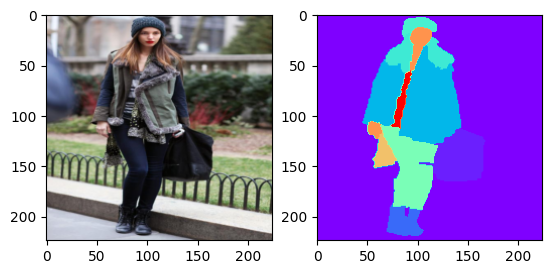

In [61]:
fig, ax = plt.subplots(1, 2)
img = x[0].numpy().transpose(1, 2, 0)
ax[0].imshow(img)
ann = torch.squeeze(y[0], dim=0)
ann = torch.argmax(ann, dim=0)
ax[1].imshow(ann, cmap='rainbow')

## Training

Using the trainer is quite easy, and it only requires a few essential input requirements:

- A model
- An optimizer
- A loss function

Additionally, the number of classes and epochs should also be passed in.

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
model = VGGUNet(59, simple=True).to(device)
opt = torch.optim.Adam(model.parameters())
loss = DiceCE(59)

In [64]:
trainer = Trainer(model=model, train_dl=train_mc_dl, n_classes=59, epochs=10, loss_function=loss, optimizer=opt)

Starting training is quite easy and has been designed to mimic Keras' `.fit` functionality. If validation is not being used, the method can simple be called without any arguments.

If validation is required you will have to pass in a validation dataloader as well as the validation flag.

Starting epoch : 1 -------------------------------------------------------------------


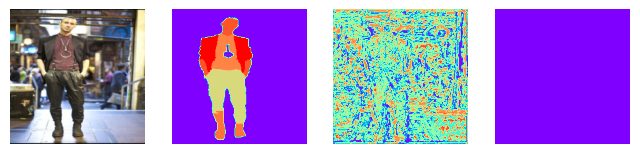

The loss on the first batch is : 5.047237396240234
Loss at epoch : 1 : 4.734
Running Validation Step


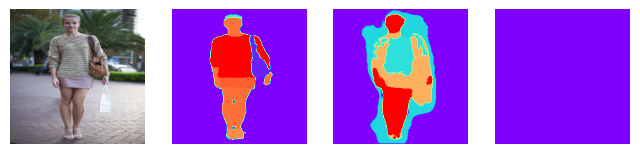

The loss on the first batch for validation is : 4.536587715148926
Validation Loss at epoch : 1 : 4.525
Validation Dice Score at epoch : 1 : 0.004
Saved model at val dice : 0.004
Epoch : 1 took 1 mins : 14 seconds


------------------------------------------------------------------------------------------






Starting epoch : 2 -------------------------------------------------------------------


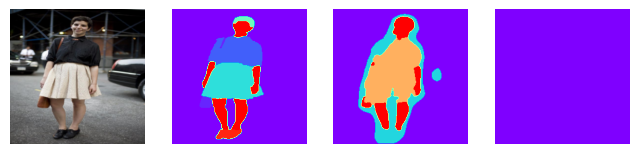

The loss on the first batch is : 4.448093891143799
Loss at epoch : 2 : 4.426
Running Validation Step


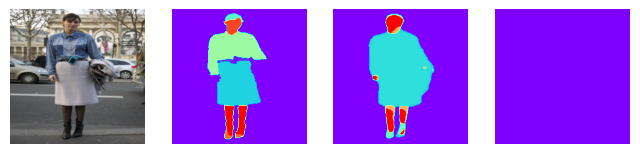

The loss on the first batch for validation is : 4.346535682678223
Validation Loss at epoch : 2 : 4.351
Validation Dice Score at epoch : 2 : 0.004
Epoch : 2 took 1 mins : 15 seconds


------------------------------------------------------------------------------------------






Starting epoch : 3 -------------------------------------------------------------------


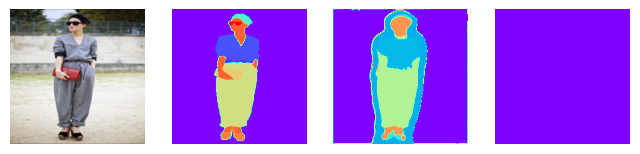

The loss on the first batch is : 4.216306209564209
Loss at epoch : 3 : 4.286
Running Validation Step


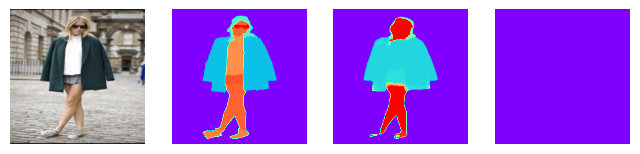

The loss on the first batch for validation is : 4.264700412750244
Validation Loss at epoch : 3 : 4.264
Validation Dice Score at epoch : 3 : 0.005
Saved model at val dice : 0.005
Epoch : 3 took 1 mins : 15 seconds


------------------------------------------------------------------------------------------






Starting epoch : 4 -------------------------------------------------------------------


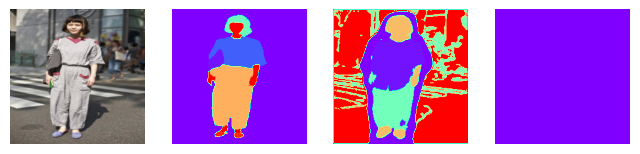

The loss on the first batch is : 4.173234939575195
Loss at epoch : 4 : 4.253
Running Validation Step


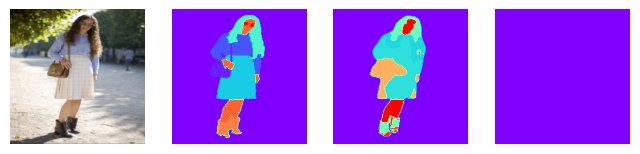

The loss on the first batch for validation is : 4.230220794677734
Validation Loss at epoch : 4 : 4.23
Validation Dice Score at epoch : 4 : 0.005
Epoch : 4 took 1 mins : 14 seconds


------------------------------------------------------------------------------------------






Starting epoch : 5 -------------------------------------------------------------------


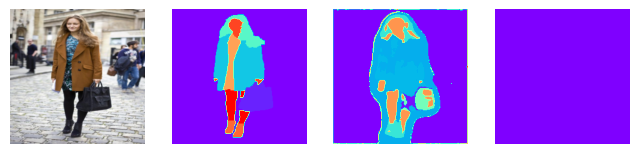

The loss on the first batch is : 4.293082237243652
Loss at epoch : 5 : 4.228
Running Validation Step


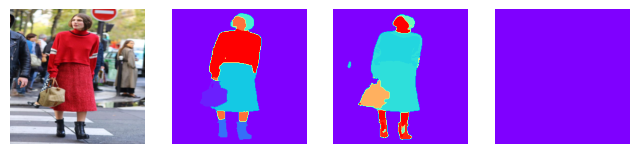

The loss on the first batch for validation is : 4.222740173339844
Validation Loss at epoch : 5 : 4.213
Validation Dice Score at epoch : 5 : 0.005
Epoch : 5 took 1 mins : 14 seconds


------------------------------------------------------------------------------------------






Starting epoch : 6 -------------------------------------------------------------------


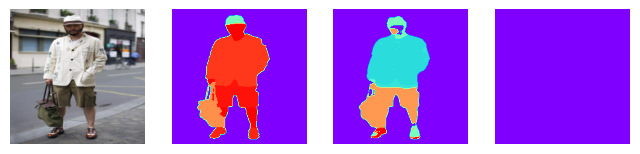

The loss on the first batch is : 4.191461563110352
Loss at epoch : 6 : 4.209
Running Validation Step


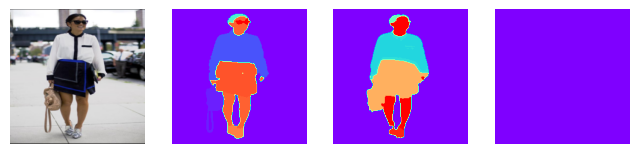

The loss on the first batch for validation is : 4.2023468017578125
Validation Loss at epoch : 6 : 4.203
Validation Dice Score at epoch : 6 : 0.005
Epoch : 6 took 1 mins : 14 seconds


------------------------------------------------------------------------------------------






Starting epoch : 7 -------------------------------------------------------------------


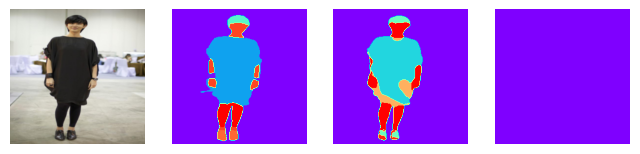

The loss on the first batch is : 4.193243503570557
Loss at epoch : 7 : 4.196
Running Validation Step


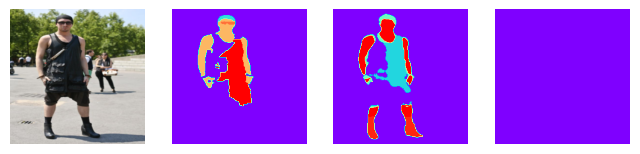

The loss on the first batch for validation is : 4.1908063888549805
Validation Loss at epoch : 7 : 4.198
Validation Dice Score at epoch : 7 : 0.005
Epoch : 7 took 1 mins : 13 seconds


------------------------------------------------------------------------------------------






Starting epoch : 8 -------------------------------------------------------------------


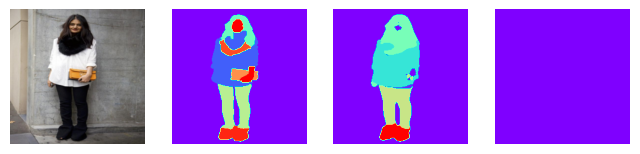

The loss on the first batch is : 4.22994327545166
Loss at epoch : 8 : 4.183
Running Validation Step


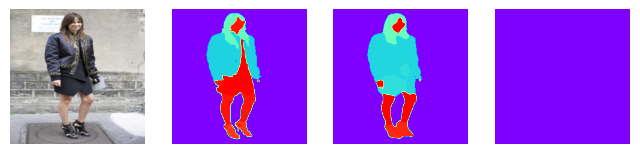

The loss on the first batch for validation is : 4.1792497634887695
Validation Loss at epoch : 8 : 4.193
Validation Dice Score at epoch : 8 : 0.005
Epoch : 8 took 1 mins : 15 seconds


------------------------------------------------------------------------------------------






Starting epoch : 9 -------------------------------------------------------------------


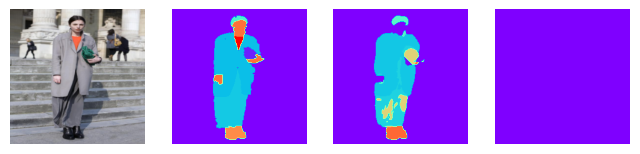

The loss on the first batch is : 4.04119348526001
Loss at epoch : 9 : 4.202
Running Validation Step


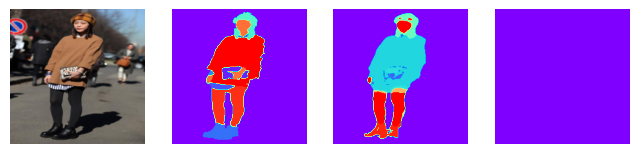

The loss on the first batch for validation is : 4.184408664703369
Validation Loss at epoch : 9 : 4.183
Validation Dice Score at epoch : 9 : 0.006
Saved model at val dice : 0.006
Epoch : 9 took 1 mins : 14 seconds


------------------------------------------------------------------------------------------






Starting epoch : 10 -------------------------------------------------------------------


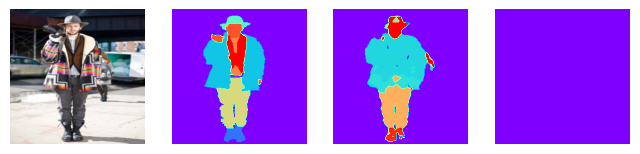

The loss on the first batch is : 4.1065874099731445
Loss at epoch : 10 : 4.183
Running Validation Step


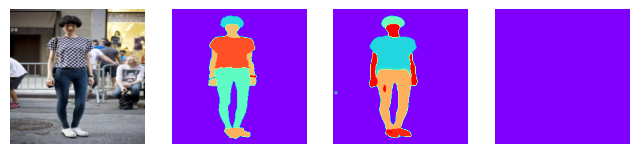

The loss on the first batch for validation is : 4.186195373535156
Validation Loss at epoch : 10 : 4.185
Validation Dice Score at epoch : 10 : 0.005
Epoch : 10 took 1 mins : 14 seconds


------------------------------------------------------------------------------------------








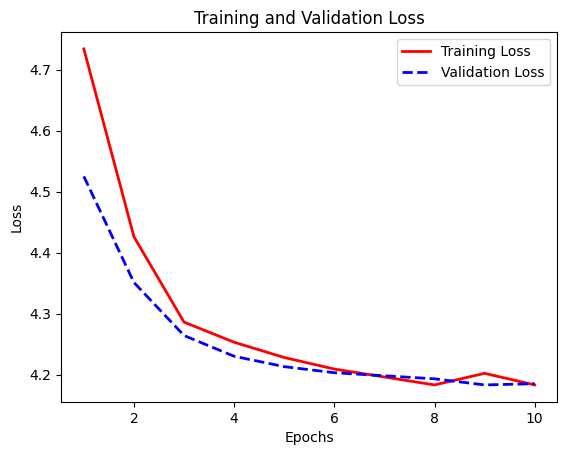

In [65]:
trainer.fit(validation=True, valid_dl=val_mc_dl)